### AWS Sagemaker Trained Models Evaluation and Feature Importance

Purpose: perform prediction, evaluate (ROC-AUC and Gini) the results and extract feature importance and feature iterations from an XGBoost classification model in a tar gz file in S3. ScriptProcessor based on xgboost image and processing job is used instead Transformer and transform job. SageMaker Model object is not used. It's still kind of an evaluation, searching of a best model process, not yet a final step.

Model scores and feature importance are extracted from S3, visualized and saved into a log file. Feature Interaction files as well as a file with predictions just exist in the output S3 bucket.

If it's configured to run on more then one model, the models can be considered as folds of the same model and the final result is an average of all models.

In [1]:
Experiments_file='/home/kate/Research/YearBuilt/Experiments/DevExperiments.xlsx'
AllExperiments_tab='Experiments'
Experiment_name='Fold1Eval'
#Experiment configuration:  
#Predict on the same dataset set but possible for different models (ModelFiles)
#1.Models: each line in the file contains the model name and set of features to built a dataset for prediction
Experiment_Features_tab='%s Models'%Experiment_name
#2.ModelFiles: each line is a model name (Model) and full model file name (ModelData - model.tar.gz) in an S3 bucket
Experiment_ModelFiles_tab='%s ModelFiles'%Experiment_name

path_to_model_evals='Data/Experiments/%s'%Experiment_name
 
bucket='kdproperty'
path_to_data_file='/Data/'

instance_type='ml.m5.xlarge'
instance_count=1

Trial_name_processing='%s-Processing'%Experiment_name
# the data used in the testing is insurance based and splitted by an accidents/claims calendar years to train/test
split_year='2020'

In [2]:
import boto3
import sys
import time
import pandas as pd
import numpy as np

import re

#to read data from S3 with pandas
import s3fs

import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role
from sagemaker.processing import ScriptProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

In [3]:
region = boto3.session.Session().region_name
role = 'arn:aws:iam::XYZ:role/service-role/AmazonSageMaker-ExecutionRole-20200819T131882'
sagemaker_session = sagemaker.session.Session(default_bucket=bucket)
s3 = s3fs.S3FileSystem()

In [4]:
#sys.path.append('/home/kate/Research/YearBuilt/Notebooks/Experiments')
import ExperimentsUtils as eu

1. Reading experiment configuration from an excel file

In [5]:
experiments = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=AllExperiments_tab)

1.1 Target variable and data file name

In [6]:
target=experiments[experiments['Experiment']==Experiment_name]['Target'].values[0]
print('Target of models in %s experiment is %s'%(Experiment_name,target))
data_file=experiments[experiments['Experiment']==Experiment_name]['Dataset'].values[0]
print('Datafile used in %s experiment is %s'%(Experiment_name,data_file))

Target of models in Fold1Eval experiment is hasclaim_water
Datafile used in Fold1Eval experiment is dwelling_basedata_v4.csv


1.2 Model files (usually model.tar.gz produced from training)
I do not create SageMaker Models in this process. It's still evaluation part and a simple ScriptProcessor is used for prediction which does not need Sagemaker Model object

In [7]:
model_files = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_ModelFiles_tab)
model_files

,Model,ModelData
0,PropertyAge,s3://kdproperty/Models/Experiments/bf2/Propert...


1.3 Model features. The process will use this info to create a data file with all needed features and map feature importance

In [8]:
model_features = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_Features_tab)
model_features

,Model,F1,F2,F3,F4
0,PropertyAge,cal_year-yearbuilt,cova_deductible,sqft,water_risk_3_blk


2.Verification if we have the same set of models in both configurations

In [9]:
models_from_model_features=model_features['Model'].tolist()
models_from_models_files=model_files['Model'].tolist()
if len([x for x in models_from_model_features if x not in models_from_models_files])!=0:
    raise Exception('Different set of models in featuresets and files!')

3.Creating experiments and trials in SageMaker. SageMaker Experiment object does not contain useful info from the process except name of the job. 

In [10]:
eu.cleanup_experiment(Experiment_name)
eu.create_experiment(Experiment_name)
eu.create_trial(Experiment_name,Trial_name_processing)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Fold1Eval is a new experiment. Nothing to delete


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


4. Processing jobs

In [11]:
%%writefile TrainedModelEvaluation.py
import argparse
import os
import sys
import subprocess
import pathlib
import pickle
import tarfile
import joblib
import numpy as np
import pandas as pd
import xgboost


#Evaluation metric
from sklearn.metrics import roc_auc_score
#To estimate models performance we need a custom gini function
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def create_fmap(ModelName,featureset):
    fmap_filename='%s.fmap'%ModelName
    outfile = open(fmap_filename, 'w')
    for i, feat in enumerate(featureset):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    return fmap_filename

if __name__=='__main__':
    
    #installing XGBFir
    XGBFirFlg = False
    try:
        xgbfir_installed = subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'xgbfir'])
        if xgbfir_installed == 0:
            import xgbfir
            XGBFirFlg = True
            print('Successfully installed XGBfir')
        else:
            print('XGBfir was not installed')
    except:
        print('XGBfir was not installed')
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_file', type=str)
    parser.add_argument('--split_year', type=int)       
    parser.add_argument('--model', type=str)
    parser.add_argument('--featureset', type=str)     
    parser.add_argument('--target', type=str)
    args, _ = parser.parse_known_args()    
    print('Received arguments {}'.format(args))
    
    featureset=args.featureset.split(',')
    target_column=args.target
    #prediction will be added into the dataset in column "model_name"
    model_name=args.model
    model_path = '/opt/ml/processing/input/model/model.tar.gz'
    input_data_path = os.path.join('/opt/ml/processing/input', args.data_file)
    metrics_data_path = '/opt/ml/processing/output_metrics/metrics.csv'
    importance_data_path = '/opt/ml/processing/output_importance/importance.csv'
    interactions_data_path = '/opt/ml/processing/output_importance/interactions_%s.xlsx'%model_name
    prediction_data_path = '/opt/ml/processing/output_prediction/prediction.csv' 
    
    print('Reading model from file %s'%model_path)
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")
    
    model = pickle.load(open('xgboost-model','rb'))

    print('Reading dataset from %s'%input_data_path)
    dataset = pd.read_csv(input_data_path, error_bad_lines=False, index_col=False)
    
    print('Creating dataset for prediction')
    test_dataset = pd.DataFrame()
    for f in featureset:
        print(f)
        test_dataset[f]=dataset.eval(f)
    dataset[target_column]=dataset.eval(target_column) 
    
    print('Creating DMatrix from dataset for prediction')
    X_test = xgboost.DMatrix(test_dataset.values)
    
    print('Prediction')
    predictions = model.predict(X_test)
    dataset[model_name]=predictions
    dataset[[model_name]].to_csv(prediction_data_path, header=True, index=False)
    
    print('Evaluation')
    test_roc_auc=roc_auc_score(dataset[(dataset.cal_year == args.split_year)][target_column], dataset[(dataset.cal_year == args.split_year)][model_name])
    train_roc_auc=roc_auc_score(dataset[(dataset.cal_year < args.split_year)][target_column], dataset[(dataset.cal_year < args.split_year)][model_name])
    
    test_gini=gini(dataset[(dataset.cal_year == args.split_year)][target_column],dataset[(dataset.cal_year == args.split_year)][model_name])/gini(dataset[(dataset.cal_year == args.split_year)][target_column],dataset[(dataset.cal_year == args.split_year)][target_column])
    train_gini=gini(dataset[(dataset.cal_year < args.split_year)][target_column],dataset[(dataset.cal_year < args.split_year)][model_name])/gini(dataset[(dataset.cal_year < args.split_year)][target_column],dataset[(dataset.cal_year < args.split_year)][target_column])
    
    TestingDataResults = pd.DataFrame(list(zip([model_name],[train_roc_auc],[test_roc_auc],[train_gini],[test_gini])), 
               columns =['Model','Train ROC-AUC','Test ROC-AUC','Train gini','Test gini'])
    
    TestingDataResults.to_csv(metrics_data_path, header=True, index=False)
    
    print('Feature Importance')
    
    fmap_filename=create_fmap(model_name,featureset)
    feat_imp = pd.Series(model.get_score(fmap=fmap_filename,importance_type='weight')).to_frame()
    feat_imp.columns=['Weight']
    feat_imp = feat_imp.join(pd.Series(model.get_score(fmap=fmap_filename,importance_type='gain')).to_frame())
    feat_imp.columns=['Weight','Gain']
    feat_imp = feat_imp.join(pd.Series(model.get_score(fmap=fmap_filename,importance_type='cover')).to_frame())
    feat_imp.columns=['Weight','Gain','Cover']
    feat_imp['FeatureName'] = feat_imp.index
    feat_imp['Model'] = model_name
    
    feat_imp.to_csv(importance_data_path, header=True, index=False)
    
    if XGBFirFlg:
        print('Feature Interaction')
        xgbfir.saveXgbFI(model, feature_names=featureset,  TopK = 500,  MaxTrees = 500, MaxInteractionDepth = 2, OutputXlsxFile = interactions_data_path)

Overwriting TrainedModelEvaluation.py


In [12]:
#joining together features and model file name for easy looping
models = pd.merge(model_features, model_files, on='Model', how='inner')
models

,Model,F1,F2,F3,F4,ModelData
0,PropertyAge,cal_year-yearbuilt,cova_deductible,sqft,water_risk_3_blk,s3://kdproperty/Models/Experiments/bf2/Propert...


In [13]:
from sagemaker.amazon.amazon_estimator import get_image_uri
processors=list()
image_uri = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='1.0-1') 
regex = re.compile('F[ 0-9]')
for index, row in models.iterrows():
    model=row['Model']

    
    featureset = []
    for c in models.columns:
        if bool(re.match(regex, c)):
            featureset.append(row[c])
    print (index, ': Prediction from model %s: %s'%(model,','.join(featureset).replace(' ','')))
    data_processor = ScriptProcessor(
    image_uri=image_uri,
    command=['python3'],
    instance_type=instance_type,
    instance_count=instance_count,
    base_job_name=model.replace('_','-'),
    role=role)

    data_processor.run(code='TrainedModelEvaluation.py',
                        inputs=[ProcessingInput(source='s3://%s%s'%(bucket,path_to_data_file+data_file),destination='/opt/ml/processing/input'),
                                ProcessingInput(source=row['ModelData'],destination='/opt/ml/processing/input/model'),                              
                               ],
                        outputs=[ProcessingOutput(output_name='metrics', source='/opt/ml/processing/output_metrics', destination='s3://%s/%s/output_metrics/%s'%(bucket,path_to_model_evals,model)),
                        ProcessingOutput(output_name='importance', source='/opt/ml/processing/output_importance', destination='s3://%s/%s/output_importance/%s'%(bucket,path_to_model_evals,model)) ,
                        ProcessingOutput(output_name='prediction', source='/opt/ml/processing/output_prediction', destination='s3://%s/%s/output_prediction/%s'%(bucket,path_to_model_evals,model))
                                ],
                        arguments=['--data_file',data_file,                                 
                                 '--model',model,
                                 '--featureset', ','.join(featureset).replace(' ',''),
                                 '--target',target,
                                 '--split_year',split_year],
                        experiment_config = {
        'ExperimentName': Experiment_name ,
        'TrialName' : Trial_name_processing,
        'TrialComponentDisplayName' : Trial_name_processing},
                        wait=False
                        )
    processors.append(data_processor)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


0 : Prediction from model PropertyAge: cal_year-yearbuilt,cova_deductible,sqft,water_risk_3_blk


INFO:sagemaker:Creating processing-job with name PropertyAge-2021-02-28-19-35-56-301



Job Name:  PropertyAge-2021-02-28-19-35-56-301
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://kdproperty/Data/dwelling_basedata_v4.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-2', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://kdproperty/Models/Experiments/bf2/PropertyAge-1-2021-02-16-16-37-37/output/model.tar.gz', 'LocalPath': '/opt/ml/processing/input/model', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-XYZ/PropertyAge-2021-02-28-19-35-56-301/input/code/TrainedModelEvaluation.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionTy

In [14]:
#wait till the rest of processing jobs complete
eu.wait_processing_jobs(processors=processors,check_every_sec=10,print_every_n_output=10,wait_min=60)

Processing job PropertyAge-2021-02-28-19-35-56-301 status: InProgress
Continue waiting...
Processing job PropertyAge-2021-02-28-19-35-56-301 status: InProgress
Continue waiting...
All Processing Jobs are Completed


5. Reading results, visualisation  and saving into the log experiment

In [15]:
#Output files locations
FileLocations_df=pd.DataFrame(columns=['Model', 'Scores', 'Importance', 'Interactions','Prediction'])
for index, row in models.iterrows():
    model=row['Model']
    ModelScores_location='s3://%s/%s/output_metrics/%s/metrics.csv'%(bucket,path_to_model_evals,model) 
    FI_location='s3://%s/%s/output_importance/%s/importance.csv'%(bucket,path_to_model_evals,model)
    Interactions_location='s3://%s/%s/output_importance/%s/interactions_%s.xlsx'%(bucket,path_to_model_evals,model,model)
    Prediction_location='s3://%s/%soutput_prediction/%s/prediction.csv'%(bucket,path_to_model_evals,model)
    FileLocations_df.loc[index]=[model, ModelScores_location,FI_location,Interactions_location,Prediction_location]

In [16]:
#Saving into the Experiment log 
eu.SaveToExperimentLog(Experiments_file, '%s OutputData'%Experiment_name, FileLocations_df)

In [17]:
Scores = pd.DataFrame()
for index, row in models.iterrows():
    model=row['Model']
    ModelScores_location='s3://%s/%s/output_metrics/%s/metrics.csv'%(bucket,path_to_model_evals,model) 
    ModelScores=pd.read_csv(ModelScores_location,  error_bad_lines=False, index_col=False) 
    Scores = Scores.append(ModelScores, ignore_index=True)

In [18]:
Scores=Scores.sort_values('Test ROC-AUC', ascending=False)
Scores

,Model,Train ROC-AUC,Test ROC-AUC,Train gini,Test gini
0,PropertyAge,0.706813,0.69613,0.413627,0.392258


In [19]:
#Saving into the Experiment log 
eu.SaveToExperimentLog(Experiments_file, '%s Scores'%Experiment_name, Scores)

<AxesSubplot:xlabel='Model'>

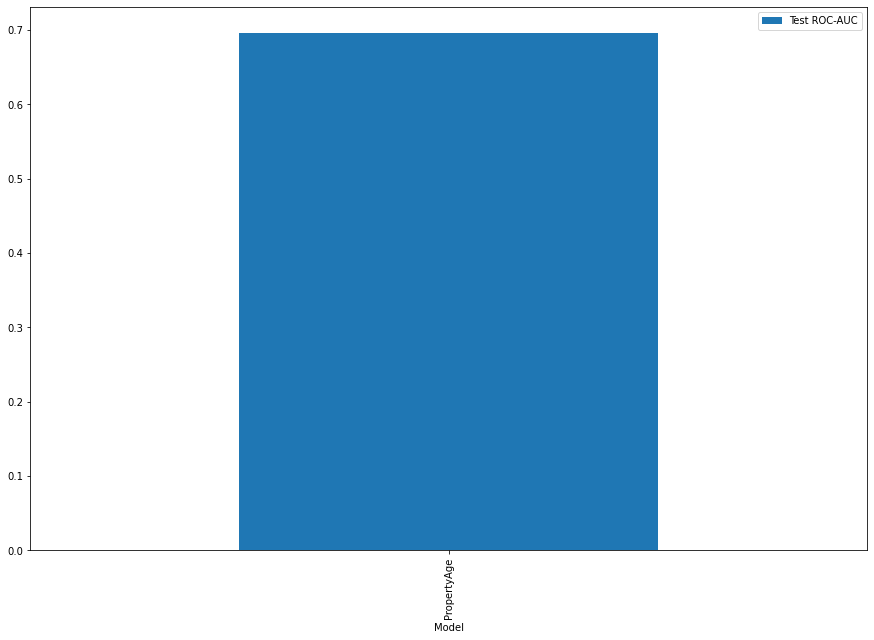

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches([15, 10])
Scores.plot.bar('Model', 'Test ROC-AUC',ax=plt.gca())

In [21]:
FeatureImportance = pd.DataFrame()
for index, row in models.iterrows():
    model=row['Model']
    FI_location='s3://%s/%s/output_importance/%s/importance.csv'%(bucket,path_to_model_evals,model) 
    ModelFeatureImportance=pd.read_csv(FI_location,  error_bad_lines=False, index_col=False) 
    FeatureImportance = FeatureImportance.append(ModelFeatureImportance, ignore_index=True)

In [22]:
FeatureImportance.head()

,Weight,Gain,Cover,FeatureName,Model
0,1550,2.156099,717.468080,cal_year-yearbuilt,PropertyAge
1,1561,1.627673,629.811404,water_risk_3_blk,PropertyAge
2,1313,1.214732,652.125363,cova_deductible,PropertyAge
3,1545,1.536305,461.960897,sqft,PropertyAge


In [23]:
#Saving into the Experiment log 
eu.SaveToExperimentLog(Experiments_file, '%s FI'%Experiment_name, FeatureImportance)

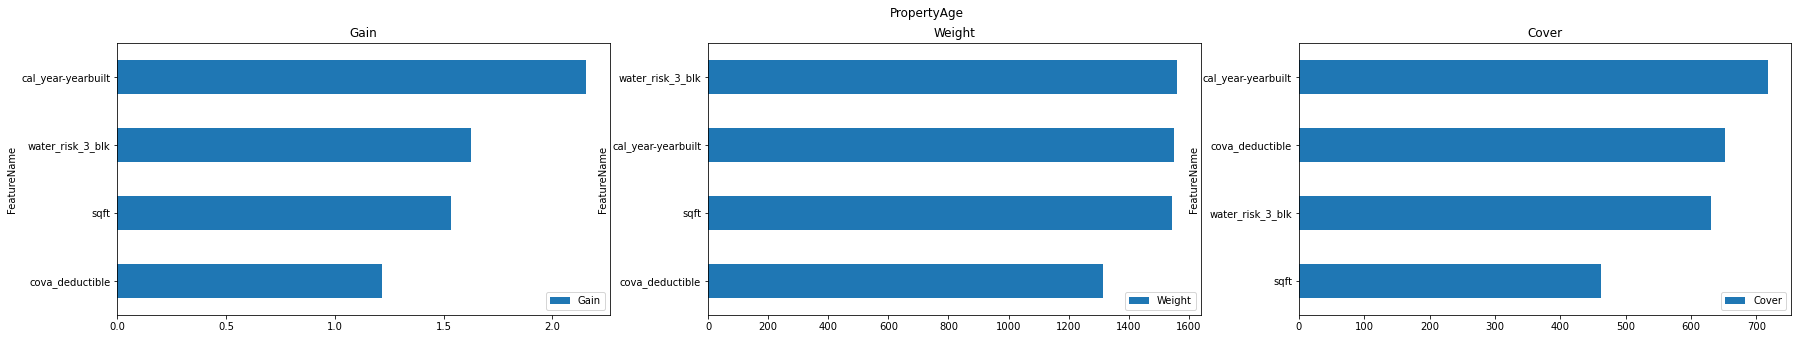

In [24]:
for index, row in models.iterrows():
    data=FeatureImportance[(FeatureImportance['Model']==row['Model'])]
    fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(30,5)) 
    fig.suptitle('%s'%(row['Model']))
    data=data.sort_values(['Model','Gain'], ascending=True)
    ax = axs[0]
    ax.set_title('Gain')
    data.plot.barh('FeatureName', 'Gain',ax=axs[0])
            
            
    data=data.sort_values(['Model','Weight'], ascending=True)
    ax = axs[1]
    ax.set_title('Weight')
    data.plot.barh('FeatureName', 'Weight',ax=axs[1])
            
    data=data.sort_values(['Model','Cover'], ascending=True)
    ax = axs[2]
    ax.set_title('Cover')
    data.plot.barh('FeatureName', 'Cover',ax=axs[2])

6. Assuming each model is a fold and calculate mean, std and sem (can be NaN if there is just one model configured)

In [25]:
FI_gain_mean=FeatureImportance.groupby(['FeatureName'])['Gain'].mean().to_frame()
FI_gain_mean.reset_index( drop=False, inplace=True )
FI_gain_mean.columns=['FeatureName','gain mean']
FI_gain_mean

,FeatureName,gain mean
0,cal_year-yearbuilt,2.156099
1,cova_deductible,1.214732
2,sqft,1.536305
3,water_risk_3_blk,1.627673


In [26]:
FI_gain_mean=FeatureImportance.groupby(['FeatureName'])['Gain'].mean().to_frame()
FI_gain_mean.reset_index( drop=False, inplace=True )
FI_gain_mean.columns=['feature','gain-mean']

FI_gain_std=FeatureImportance.groupby(['FeatureName'])['Gain'].std().to_frame()
FI_gain_std.reset_index( drop=False, inplace=True )
FI_gain_std.columns=['feature','gain-std']

FI_gain_sem=FeatureImportance.groupby(['FeatureName'])['Gain'].std().to_frame()
FI_gain_sem.reset_index( drop=False, inplace=True )
FI_gain_sem.columns=['feature','gain-sem']

FeatureImportance_df=pd.merge(FI_gain_mean,FI_gain_std,  on=['feature'], how='inner')
FeatureImportance_df=pd.merge(FeatureImportance_df,FI_gain_sem,  on=['feature'], how='inner')

FI_weight_mean=FeatureImportance.groupby(['FeatureName'])['Weight'].mean().to_frame()
FI_weight_mean.reset_index( drop=False, inplace=True )
FI_weight_mean.columns=['feature','weight-mean']

FI_weight_std=FeatureImportance.groupby(['FeatureName'])['Weight'].std().to_frame()
FI_weight_std.reset_index( drop=False, inplace=True )
FI_weight_std.columns=['feature','weight-std']

FI_weight_sem=FeatureImportance.groupby(['FeatureName'])['Weight'].std().to_frame()
FI_weight_sem.reset_index( drop=False, inplace=True )
FI_weight_sem.columns=['feature','weight-sem']

FeatureImportance_df=pd.merge(FeatureImportance_df,FI_weight_mean,  on=['feature'], how='inner')
FeatureImportance_df=pd.merge(FeatureImportance_df,FI_weight_std,  on=['feature'], how='inner')
FeatureImportance_df=pd.merge(FeatureImportance_df,FI_weight_sem,  on=['feature'], how='inner')


FI_cover_mean=FeatureImportance.groupby(['FeatureName'])['Cover'].mean().to_frame()
FI_cover_mean.reset_index( drop=False, inplace=True )
FI_cover_mean.columns=['feature','cover-mean']

FI_cover_std=FeatureImportance.groupby(['FeatureName'])['Cover'].std().to_frame()
FI_cover_std.reset_index( drop=False, inplace=True )
FI_cover_std.columns=['feature','cover-std']

FI_cover_sem=FeatureImportance.groupby(['FeatureName'])['Cover'].std().to_frame()
FI_cover_sem.reset_index( drop=False, inplace=True )
FI_cover_sem.columns=['feature','cover-sem']

FeatureImportance_df=pd.merge(FeatureImportance_df,FI_cover_mean,  on=['feature'], how='inner')
FeatureImportance_df=pd.merge(FeatureImportance_df,FI_cover_std,  on=['feature'], how='inner')
FeatureImportance_df=pd.merge(FeatureImportance_df,FI_cover_sem,  on=['feature'], how='inner')

FeatureImportance_df

,feature,gain-mean,gain-std,gain-sem,weight-mean,weight-std,weight-sem,cover-mean,cover-std,cover-sem
0,cal_year-yearbuilt,2.156099,NaN,NaN,1550,NaN,NaN,717.468080,NaN,NaN
1,cova_deductible,1.214732,NaN,NaN,1313,NaN,NaN,652.125363,NaN,NaN
2,sqft,1.536305,NaN,NaN,1545,NaN,NaN,461.960897,NaN,NaN
3,water_risk_3_blk,1.627673,NaN,NaN,1561,NaN,NaN,629.811404,NaN,NaN


/home/kate/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
<ipython-input-27-1d2fb68247bb>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data['feature'].values,rotation=90)
<ipython-input-27-1d2fb68247bb>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data['feature'].values,rotation=90)
<ipython-input-27-1d2fb68247bb>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data['feature'].values,rotation=90)


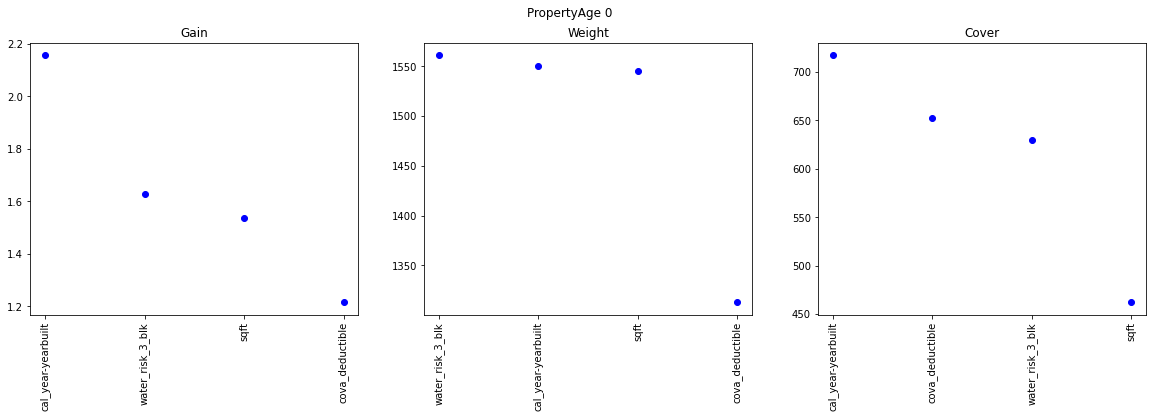

In [27]:
for index, row in models.iterrows():
        data=FeatureImportance_df.sort_values('gain-mean',ascending=False)
        fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(20,5)) 
        fig.suptitle('%s %s'%(row['Model'],index))
                
        ax = axs[0]
        ax.errorbar(data['feature'], data['gain-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['gain-sem'], fmt='o')
        ax.set_title('Gain')
        ax.set_xticklabels(data['feature'].values,rotation=90)
           
 
        data=data.sort_values('weight-mean',ascending=False)
        ax = axs[1]
        ax.errorbar(data['feature'], data['weight-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['weight-sem'], fmt='o')
        ax.set_title('Weight')
        ax.set_xticklabels(data['feature'].values,rotation=90)
                         
        data=data.sort_values('cover-mean',ascending=False)
        ax = axs[2]
        ax.errorbar(data['feature'], data['cover-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['weight-sem'], fmt='o')
        ax.set_title('Cover')
        ax.set_xticklabels(data['feature'].values,rotation=90)

In [ ]:
#joining predicted data from each model to the original dataset
#maybe no need to download locally but rather run one more ScriptProcessor
#to have a complete dataset in S3 and load to Redshift directly
#For Shap Values we need a batch transform job

In [29]:
#original dataset
#can be read from S3: 's3://%s%s'%(bucket,path_to_data_file+data_file)
#or locally
data_file='dwelling_basedata_v4.csv'
dataset=pd.read_csv('/home/kate/Research/YearBuilt/Data/'+data_file,  error_bad_lines=False, index_col=False) 

In [30]:
columns=list()
for index, row in models.iterrows():
    model=row['Model']
    Prediction_location='s3://%s/%s/output_prediction/%s/prediction.csv'%(bucket,path_to_model_evals,model)
    ModelPredictionData=pd.read_csv(Prediction_location,  error_bad_lines=False, index_col=False)
    columns.append(ModelPredictionData.columns[0])
    dataset = pd.concat([dataset,ModelPredictionData],axis=1)

Average prediction from all folds

In [31]:
#Evaluation metric
from sklearn.metrics import roc_auc_score
#To estimate models performance we need a custom gini function
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

In [32]:
dataset['Prediction']=0
for c in columns:
    dataset[c]=pd.to_numeric(dataset[c])
    dataset['Prediction']=dataset['Prediction']+dataset[c]
dataset['Prediction']=dataset['Prediction']/len(columns)    

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [33]:
model='Prediction'
test_roc_auc=roc_auc_score(dataset[(dataset.cal_year == int(split_year))][target], dataset[(dataset.cal_year == int(split_year))][model])
train_roc_auc=roc_auc_score(dataset[(dataset.cal_year < int(split_year))][target], dataset[(dataset.cal_year < int(split_year))][model])
    
test_gini=gini(dataset[(dataset.cal_year == int(split_year))][target],dataset[(dataset.cal_year == int(split_year))][model])/gini(dataset[(dataset.cal_year == int(split_year))][target],dataset[(dataset.cal_year == int(split_year))][target])
train_gini=gini(dataset[(dataset.cal_year < int(split_year))][target],dataset[(dataset.cal_year < int(split_year))][model])/gini(dataset[(dataset.cal_year < int(split_year))][target],dataset[(dataset.cal_year < int(split_year))][target])
    
TestingDataResults = pd.DataFrame(list(zip(['Final'],[train_roc_auc],[test_roc_auc],[train_gini],[test_gini])), 
               columns =['Model','Train ROC-AUC','Test ROC-AUC','Train gini','Test gini'])
TestingDataResults

,Model,Train ROC-AUC,Test ROC-AUC,Train gini,Test gini
0,Final,0.706813,0.69613,0.413627,0.392258


In [34]:
Scores=Scores.append(TestingDataResults, ignore_index=True)

In [35]:
Scores=Scores.sort_values('Test ROC-AUC', ascending=False)
Scores

,Model,Train ROC-AUC,Test ROC-AUC,Train gini,Test gini
0,PropertyAge,0.706813,0.69613,0.413627,0.392258
1,Final,0.706813,0.69613,0.413627,0.392258


In [36]:
#Saving into the Experiment log 
eu.SaveToExperimentLog(Experiments_file, '%s Scores'%Experiment_name, Scores)

<AxesSubplot:xlabel='Model'>

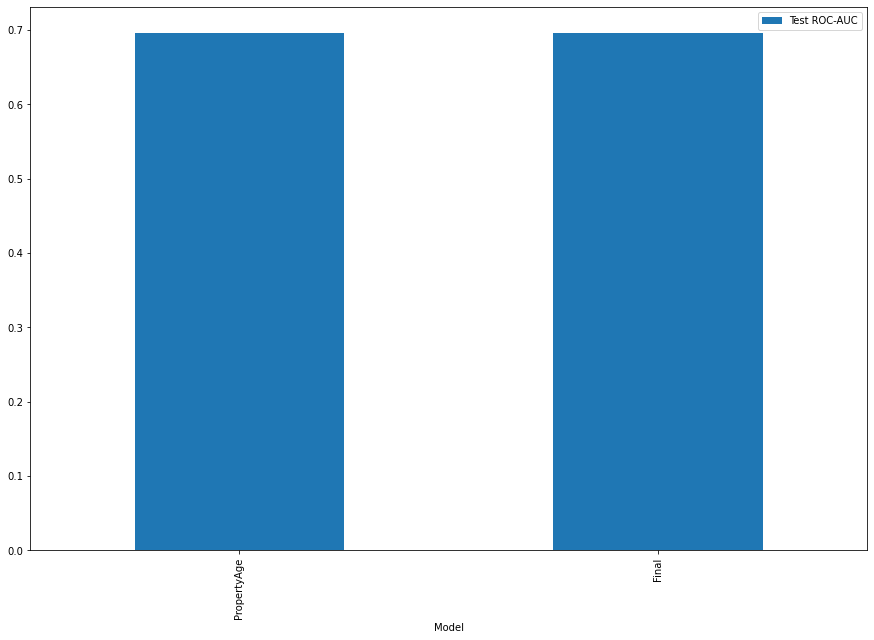

In [37]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches([15, 10])
Scores.plot.bar('Model', 'Test ROC-AUC',ax=plt.gca())